## SMM Estimation of Theories of Expectation Formation with Inflation Expectation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import types
from numba.typed import Dict,List
import pandas as pd
from statsmodels.tsa.api import AutoReg as AR
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('ggplot')

## figure config

lw = 4  #line width


## Model

In [2]:
from SMMEst import SimAR1, SimUCSV,ObjGen, ObjWeight,ParaEst,type_list

from SMMEst import StickyExpectationAR, StickyExpectationSV
from SMMEst import NoisyInformationAR, NoisyInformationSV
from SMMEst import DiagnosticExpectationAR, DiagnosticExpectationSV
from SMMEst import DENIHybridAR, DENIHybridSV


In [3]:
## create some fake parameters and data to initialize model class
### not used for estimation

## AR1 parameters
ρ0,σ0 = 0.98, 0.10

history0 = SimAR1(ρ0,
                  σ0,
                  200)
real_time0 = history0[11:-2]

realized0 = history0[12:-1]

### UCSV inflation

p0_fake = 0 ## initial permanent component
γ_fake = 0.1 ## size of shock to the volatility
σs_now_fake = [0.2,0.3] ## volatility of permanent and transitory component

ucsv_fake = SimUCSV(γ_fake,
                    nobs = 200,
                    p0 = p0_fake,
                    )

xx_real_time,xx_p_real_time,vol_p_real_time,vol_t_real_time = ucsv_fake

xx_realized = xx_real_time[1:-1]

xx_real_time= np.array([xx_real_time,
                        xx_p_real_time,
                        vol_p_real_time,
                        vol_t_real_time]
                      )[:,0:-2]

### Sticky Expectation (SE) + AR1

### Sticky Expectation (SE) + SV

In [4]:
## initialize the ar instance
sear0 = StickyExpectationAR(exp_para = np.array([0.2]),
                            process_para = np.array([ρ0,σ0]),
                            real_time = real_time0,
                            history = history0,
                            horizon = 1)

sear0.GetRealization(realized0)

In [5]:
## initialize the sv instance
sesv0 = StickyExpectationSV(exp_para = np.array([0.3]),
                           process_para = np.array([0.1]),
                           real_time = xx_real_time,
                           history = xx_real_time) ## history does not matter here, 

## get the realization 

sesv0.GetRealization(xx_realized)

### Noisy Information (NI) + AR1


### Noisy Information (NI) + SV



In [6]:
## initialize the ar instance
niar0 = NoisyInformationAR(exp_para = np.array([0.1,0.2]),
                            process_para = np.array([ρ0,σ0]),
                            real_time = real_time0,
                            history = history0,
                            horizon = 1)

niar0.GetRealization(realized0)

In [7]:
## initial a sv instance
nisv0 = NoisyInformationSV(exp_para = np.array([0.3,0.2]),
                           process_para = np.array([0.1]),
                           real_time = xx_real_time,
                           history = xx_real_time) ## history does not matter here, 

## get the realization 

nisv0.GetRealization(xx_realized)

###  Diagnostic Expectation(DE) + AR1

###  Diagnostic Expectation(DE) + SV

In [8]:
## initialize the ar instance
dear0 = DiagnosticExpectationAR(exp_para = np.array([0.5,0.2]),
                                process_para = np.array([ρ0,σ0]),
                                real_time = real_time0,
                                history = history0,
                                horizon = 1)

dear0.GetRealization(realized0)

In [9]:
## initial a sv instance
desv0 = DiagnosticExpectationSV(exp_para = np.array([0.3,0.2]),
                               process_para = np.array([0.1]),
                               real_time = xx_real_time,
                               history = xx_real_time) ## history does not matter here, 

## get the realization 

desv0.GetRealization(xx_realized)

###  Diagnostic Expectation and Noisy Information Hybrid(DENI) + AR1

###  Diagnostic Expectation and Noisy Information Hybrid(DENI) + SV



In [10]:
## initialize the ar instance
deniar0 = DENIHybridAR(exp_para = np.array([0.1,0.3]),
                       process_para = np.array([ρ0,σ0]),
                            real_time = real_time0,
                            history = history0,
                            horizon = 1)

deniar0.GetRealization(realized0)

In [11]:
## initial a sv instance
denisv0 = DENIHybridSV(exp_para = np.array([0.1,0.2]),
                           process_para = np.array([0.1]),
                           real_time = xx_real_time,
                           history = xx_real_time) ## history does not matter here, 

## get the realization 

denisv0.GetRealization(xx_realized)

## Data Estimation  

### Prepare the data 

#### Real-time Inflation data

In [12]:
import pandas as pd
real_time_index = pd.read_excel('../OtherData/RealTimeData/RealTimeInfQ.xlsx')

real_time_index.index = pd.to_datetime(real_time_index['DATE'],format='%Y%m%d')
real_time_index = real_time_index.drop(columns=['DATE'])

## turn index into yearly inflation
#real_time_index = pd.concat([real_time_cpic,real_time_cpi], join='inner', axis=1)
real_time_index.columns=['RTCPI','RTCPICore']
real_time_inf = real_time_index.pct_change(periods=12)*100  ## year-over-year inflation, standard 
real_time_inf = real_time_inf.dropna()

#### Inflation data 

In [13]:
###############
## monthly ### 
##############

InfM = pd.read_stata('../OtherData/InfM.dta')
InfM = InfM[-InfM.date.isnull()]
dateM = pd.to_datetime(InfM['date'],format='%Y%m%d')

InfM.index = pd.DatetimeIndex(dateM,
                              freq='infer')

###############
## quarterly ##
###############

InfQ = InfM.resample('Q').last()
dateQ = pd.to_datetime(InfQ['date'],format='%Y%m%d')

dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)

InfQ.index = pd.DatetimeIndex(dateQ_str,freq='infer')

###########################
#keep only needed variables 
############################

InfM = InfM[['Inf1y_CPIAU',
             'Inf1yf_CPIAU']]

InfQ = InfQ[['Inf1y_CPICore',
            'Inf1yf_CPICore']]

#### Expectation data

In [14]:
## expectation data from SPF 

PopQ = pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]
dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')
dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str)
SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']].dropna(how='any')

## expectation data from SCE
PopM = pd.read_stata('../SurveyData/InfExpM.dta')
PopM = PopM[-PopM.date.isnull()]
dateM = pd.to_datetime(PopM['date'],format='%Y%m%d')
dateM_str = dateM.dt.year.astype(int).astype(str) + \
             "M" + dateM.dt.month.astype(int).astype(str)
PopM.index = pd.DatetimeIndex(dateM)

SCECPI = PopM[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var',
              'SCE_Mean_rd','SCE_FE_rd','SCE_Disg_rd','SCE_Var_rd']].dropna(how='any')

<AxesSubplot:title={'center':'SCE Expectations'}, xlabel='date'>

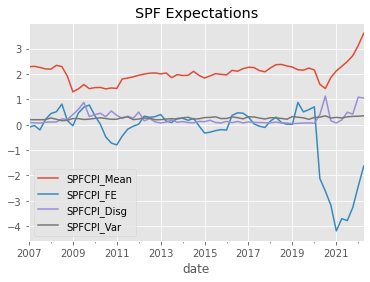

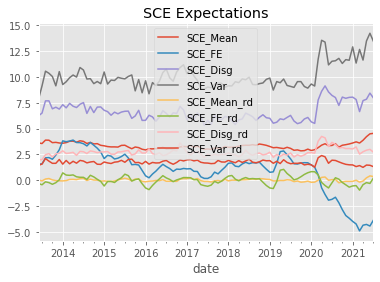

In [15]:
## plot times eries of 

SPFCPI.plot(title='SPF Expectations')

SCECPI.plot(title='SCE Expectations')

In [16]:
import datetime

## tempoary date used to check the data moments 

end_date_late = datetime.datetime(2023, 3, 30)
end_date_early = datetime.datetime(2020, 3, 30)

## we only focus on 4th quarter observations from SPF 
SPFCPI = SPFCPI[SPFCPI.index.quarter==4]

In [17]:
print('SCE\n')
print(SCECPI.mean())
print('sample period, begin at '+str(SCECPI.index[0])+', and end at '+str(SCECPI.index[-1]))
print('\n')
print('before 2020\n')
print(SCECPI[SCECPI.index<end_date_early].mean())

print('\n')

print('SPF (only in the forth quarter)\n')
print(SPFCPI.mean())
print('sample period, begin at '+str(SPFCPI.index[0])+', and end at '+str(SPFCPI.index[-1]))
print('\n')

print('before 2020\n')
print(SPFCPI[SPFCPI.index<end_date_early].mean())

SCE

SCE_Mean       3.34
SCE_FE         0.95
SCE_Disg       6.62
SCE_Var       10.08
SCE_Mean_rd    0.00
SCE_FE_rd     -0.00
SCE_Disg_rd    2.70
SCE_Var_rd     1.73
dtype: float64
sample period, begin at 2013-06-01 00:00:00, and end at 2021-07-01 00:00:00


before 2020

SCE_Mean       3.27
SCE_FE         1.75
SCE_Disg       6.35
SCE_Var        9.64
SCE_Mean_rd   -0.01
SCE_FE_rd      0.06
SCE_Disg_rd    2.60
SCE_Var_rd     1.75
dtype: float64


SPF (only in the forth quarter)

SPFCPI_Mean    2.02
SPFCPI_FE     -0.32
SPFCPI_Disg    0.18
SPFCPI_Var     0.22
dtype: float64
sample period, begin at 2007-10-01 00:00:00, and end at 2021-10-01 00:00:00


before 2020

SPFCPI_Mean   1.97
SPFCPI_FE     0.12
SPFCPI_Disg   0.16
SPFCPI_Var    0.21
dtype: float64


In [18]:
## filter sample period 

## SPF
SPFCPI = SPFCPI[SPFCPI.index<end_date_early]

## SCE
SCECPI = SCECPI[SCECPI.index<end_date_early]

In [19]:
## Combine expectation data and real-time data 

SPF_est= pd.concat([SPFCPI,
                    real_time_inf,
                    InfQ], 
                   join='inner', 
                   axis=1)

SCE_est = pd.concat([SCECPI,
                     real_time_inf,
                     InfM], 
                    join='inner', 
                    axis=1)

#### History data 

In [20]:
## process parameters estimation AR1 
# period filter 
start_t='1995-01-01'
end_t = '2020-3-30'   ## 

######################
### quarterly data ##
#####################

CPICQ = InfQ['Inf1y_CPICore'].copy().loc[start_t:end_t]

print('for SPF moments estimation, the sample is between '+str(start_t)+' and '+str(end_t))

###################
### monthly data ##
###################

CPIM = InfM['Inf1y_CPIAU'].copy().loc[start_t:end_t]

print('for SPF moments estimation, the sample is between '+str(start_t)+' and '+str(end_t))

for SPF moments estimation, the sample is between 1995-01-01 and 2020-3-30
for SPF moments estimation, the sample is between 1995-01-01 and 2020-3-30


In [21]:
## history data, the series ends at the same dates with real-time data but startes earlier

st_t_history = '2000-01-01'
ed_t_SPF = SPF_est.index[-1].strftime('%Y%m%d')
ed_t_SCE = SCE_est.index[-1].strftime('%Y-%m-%d')

## get the quarterly index 
indexQ = CPICQ.index

## get history data quarterly and monthly respectively 
af = indexQ >= st_t_history 
bf = indexQ <=ed_t_SPF
time_filter = np.logical_and(af,bf)
time_filter_idx = indexQ[time_filter]

historyQ = real_time_inf.loc[time_filter_idx]
historyM = real_time_inf.loc[st_t_history:ed_t_SCE]

#### Realization data

In [22]:
## realized 1-year-ahead inflation

realized_CPIC = np.array(SPF_est['Inf1yf_CPICore']) 
realized_CPI = np.array(SCE_est['Inf1yf_CPIAU']) 

#### AR1 parameters 

In [23]:
######################
### quarterly data ##
#####################

CPICQ_demean = CPICQ

ARmodel = AR(CPICQ_demean,lags=[1],trend='n') 
ar_rs = ARmodel.fit()
rhoQ_est = ar_rs.params[0]
#if rhoQ_est>1.0:
#    rhoQ_est = 1.0
sigmaQ_est = np.sqrt(ar_rs.sigma2) #np.sqrt(sum(ar_rs.resid**2)/(len(CPIM)-1))

###################
### monthly data ##
###################

CPIM_demean = CPIM
ARmodel2 = AR(CPIM_demean,lags=[1],trend='n') ## 12 months of lags!
ar_rs2 = ARmodel2.fit()
rhoM_est = ar_rs2.params[0]
#if rhoM_est>1.0:
#    rhoM_est = 1.0
sigmaM_est = np.sqrt(ar_rs2.sigma2)  # or np.sqrt(sum(ar_rs2.resid**2)/(len(CPIM)-1))

In [24]:
print('For the sample before', str(end_t))

print('quarterly AR(1) estimates for CPI core:')
print(rhoQ_est)
print(sigmaQ_est)
print('monthly AR(1) estimates for CPI headline:')
print(rhoM_est)
print(sigmaM_est)

For the sample before 2020-3-30
quarterly AR(1) estimates for CPI core:
0.9898446983307985
0.22568422332177593
monthly AR(1) estimates for CPI headline:
0.9849489650610844
0.40642152927029396


#### Data moments 

In [25]:
#####################################
## preparing data moments
#####################################

## Be careful with the frequency here when computing auto-correlation!!!!!
### SPF: quarters 
### SCE: month

#####################
## Professionals ####
#####################

### inflation moments 

realized_CPIC = realized_CPIC[~np.isnan(realized_CPIC)]
InfAV_data = np.mean(realized_CPIC-np.mean(realized_CPIC))
InfVar_data = np.var(realized_CPIC)
InfATV_data = np.cov(np.stack( (realized_CPIC[1:],realized_CPIC[:-1]),axis = 0 ))[0,1]
## annual autocovariance

### expectation moments 
exp_data_SPF = SPF_est[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']]
exp_data_SPF = exp_data_SPF.rename(columns={"SPFCPI_Mean": "Forecast", "SPFCPI_FE": "FE",
                            "SPFCPI_Disg":"Disg","SPFCPI_Var":"Var"})

FEs_data = exp_data_SPF['FE']
Disgs_data = exp_data_SPF['Disg']
Vars_data = exp_data_SPF['Var']

FE_data = np.mean(FEs_data)
FEVar_data = np.var(FEs_data)
FEATV_data = np.cov(np.stack( (FEs_data[1:],FEs_data[:-1]),axis = 0))[0,1]  ## one quarter apart 
## annual autocovariance


Disg_data = np.mean(Disgs_data)
DisgVar_data = np.var(Disgs_data)
DisgATV_data = np.cov(np.stack( (Disgs_data[1:],Disgs_data[:-1]),axis = 0))[0,1]
Var_data = np.mean(Vars_data)
VarVar_data = np.var(Vars_data)
VarATV_data = np.cov(np.stack( (Vars_data[1:],Vars_data[:-1]),axis = 0))[0,1]
## annual autocovariance



data_moms_dct_SPF = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64,
)
data_moms_dct_SPF['InfAV'] = InfAV_data
data_moms_dct_SPF['InfVar'] = InfVar_data
data_moms_dct_SPF['InfATV'] = InfATV_data

data_moms_dct_SPF['FE'] = FE_data
data_moms_dct_SPF['FEVar'] = FEVar_data
data_moms_dct_SPF['FEATV'] = FEATV_data
data_moms_dct_SPF['Disg'] = Disg_data
data_moms_dct_SPF['DisgVar'] = DisgVar_data
data_moms_dct_SPF['DisgATV'] = DisgATV_data
data_moms_dct_SPF['Var'] = Var_data
data_moms_dct_SPF['VarVar'] = VarVar_data
data_moms_dct_SPF['VarATV'] = VarATV_data


##########################
### For households 
##########################

#############################################################################################
############!!!!! using "xx_rd" moments only if one wants to control for individual fixed effects
###########################################################################################

control_ind_fe = True

if control_ind_fe:
    exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg_rd','SCE_Var_rd']]
    exp_data_SCE = exp_data_SCE.rename(columns={"SCE_Mean": "Forecast", "SCE_FE": "FE",
                                            "SCE_Disg_rd":"Disg","SCE_Var_rd":"Var"})
else:
    exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']]
    exp_data_SCE = exp_data_SCE.rename(columns={"SCE_Mean": "Forecast", "SCE_FE": "FE",
                                            "SCE_Disg":"Disg","SCE_Var":"Var"})

## inflation moments 

realized_CPI = realized_CPI[~np.isnan(realized_CPI)]

InfAV_data = np.mean(realized_CPI-np.mean(realized_CPI))
InfVar_data = np.var(realized_CPI)
InfATV_data = np.cov(np.stack( (realized_CPI[1:],realized_CPI[:-1]),axis = 0 ))[0,1]

## expectation moments 
FEs_data = exp_data_SCE['FE']
Disgs_data = exp_data_SCE['Disg']
Vars_data = exp_data_SCE['Var']

FE_data = np.mean(FEs_data)
FEVar_data = np.var(FEs_data)
FEATV_data = np.cov(np.stack( (FEs_data[1:],FEs_data[:-1]),axis = 0 ))[0,1]

Disg_data = np.mean(Disgs_data)
DisgVar_data = np.var(Disgs_data)
DisgATV_data = np.cov(np.stack( (Disgs_data[1:],Disgs_data[:-1]),axis = 0))[0,1]
Var_data = np.mean(Vars_data)
VarVar_data = np.var(Vars_data)
VarATV_data = np.cov(np.stack( (Vars_data[1:],Vars_data[:-1]),axis = 0))[0,1]


data_moms_dct_SCE = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64,
)
data_moms_dct_SCE['InfAV'] = InfAV_data
data_moms_dct_SCE['InfVar'] = InfVar_data
data_moms_dct_SCE['InfATV'] = InfATV_data
data_moms_dct_SCE['FE'] = FE_data
data_moms_dct_SCE['FEVar'] = FEVar_data
data_moms_dct_SCE['FEATV'] = FEATV_data
data_moms_dct_SCE['Disg'] = Disg_data
data_moms_dct_SCE['DisgVar'] = DisgVar_data
data_moms_dct_SCE['DisgATV'] = DisgATV_data
data_moms_dct_SCE['Var'] = Var_data
data_moms_dct_SCE['VarVar'] = VarVar_data
data_moms_dct_SCE['VarATV'] = VarATV_data

############# need to compute the unconditional moments here 

In [26]:
print('SPF\n')
print(dict(data_moms_dct_SPF))
print('\n')
print('SCE\n')
print(dict(data_moms_dct_SCE))

SPF

{'InfAV': 1.0086939994380373e-07, 'InfVar': 0.17017723619937897, 'InfATV': -0.0356729463653195, 'FE': 0.12488741427659988, 'FEVar': 0.13613413274288177, 'FEATV': -0.0505739596773157, 'Disg': 0.16117419302463531, 'DisgVar': 0.018073327839374542, 'DisgATV': 0.012411878644727953, 'Var': 0.21303563107977663, 'VarVar': 0.00029486240333176323, 'VarATV': 0.00015429240798600462}


SCE

{'InfAV': 4.361315308898384e-09, 'InfVar': 0.6527659893035889, 'InfATV': 0.6088165481962265, 'FE': 1.7494832277297974, 'FEVar': 0.9224221706390381, 'FEATV': 0.8780810857964563, 'Disg': 2.6003129482269287, 'DisgVar': 0.07243034988641739, 'DisgATV': 0.02432683497151849, 'Var': 1.7492247819900513, 'VarVar': 0.02738690935075283, 'VarATV': 0.002872353202983449}


#### model moments 

In [27]:
fire_ar_mom_dct = {'InfAV':0.0,
           'InfVar':r'$\sigma^2_\omega/(1-\rho^2)$',
           'InfATV':r'$\rho\sigma^2_\omega/(1-\rho^2)$',
           'FE':0.0,
           'FEVar':r'$\sigma^2_\omega$',
           'FEATV':0.0,
           'Disg':0.0,
           'DisgVar':0.0,
           'DisgATV':0.0,
           'Var':r'$\sigma^2_\omega$',
            'VarVar':0.0,
            'VarATV':0.0
           }

fire_ar_mom = pd.DataFrame([dict(fire_ar_mom_dct)])
fire_ar_mom.index = ['FIRE+AR']


fire_sv_mom_dct = {'InfAV':0.0,
           'InfVar':'N/A',
           'InfATV':'N/A',
           'FE':0.0,
           'FEVar':r'$\bar\sigma^2_{\eta}+\bar\sigma^2_{z}$',
           'FEATV':0.0,
           'Disg':0.0,
           'DisgVar':0.0,
           'DisgATV':0.0,
           'Var':r'$\bar\sigma^2_{\eta}+\bar\sigma^2_{z}$',
            'VarVar':'>0',
            'VarATV':'>0'
           }

fire_sv_mom = pd.DataFrame([dict(fire_sv_mom_dct)])
fire_sv_mom.index = ['FIRE+SV']


## these moments have not been used yet 
## need to make sure all is correct 

sear_mom_dct = {'InfAV':0.0,
           'InfVar':r'$\sigma^2_\omega/(1-\rho^2)$',
           'InfATV':r'$\rho\sigma^2\omega/(1-\rho^2)$',
           'FE':0.0,
           'FEVar':r'$\lambda^2\sigma^2/(1-(1-\lambda)^2\rho^2)$',
           'FEATV':r'$(1-\lambda)\rho\text{FEVar}$',
           'Disg':0.0,
           'DisgVar':0.0,
           'DisgATV':0.0,
           'Var':r'$\sigma^2$',
            'VarVar':0.0,
            'VarATV':0.0
           }

sear_mom = pd.DataFrame([sear_mom_dct])
sear_mom.index = ['SE+AR']

In [28]:
## data_moments 


data_mom_SPF = pd.DataFrame([dict(data_moms_dct_SPF)])
data_mom_SPF.index = ['SPF']
data_mom_SCE = pd.DataFrame([dict(data_moms_dct_SCE)])
data_mom_SCE.index = ['SCE']

data_mom_df = pd.concat([data_mom_SPF,
                         data_mom_SCE,
                         fire_ar_mom,
                        fire_sv_mom])

data_mom_df = data_mom_df.applymap(lambda x: round(x, 3) 
                                   if isinstance(x, (int, float)) else x)


### keep only selected moments 

data_mom_df = data_mom_df.drop(columns=['FEATV',
                                        'DisgVar',
                                        'DisgATV',
                                        'VarVar',
                                        'VarATV'])

data_mom_df.T.to_excel('tables/data_moments.xlsx')
data_mom_df.T

,SPF,SCE,FIRE+AR,FIRE+SV
InfAV,0.00,0.00,0.00,0.00
InfVar,0.17,0.65,$\sigma^2_\omega/(1-\rho^2)$,N/A
InfATV,-0.04,0.61,$\rho\sigma^2_\omega/(1-\rho^2)$,N/A
FE,0.12,1.75,0.00,0.00
FEVar,0.14,0.92,$\sigma^2_\omega$,$\bar\sigma^2_{\eta}+\bar\sigma^2_{z}$
Disg,0.16,2.60,0.00,0.00
Var,0.21,1.75,$\sigma^2_\omega$,$\bar\sigma^2_{\eta}+\bar\sigma^2_{z}$


### Data moments

In [29]:
## real time and history 

################
## quarterly ###
#################

real_time_Q_ar = np.array(SPF_est['RTCPICore'])
history_Q_ar = np.array(historyQ['RTCPICore'])
process_paraQ_est_ar = np.array([rhoQ_est,sigmaQ_est])

##############
## monthly ###
#############

real_time_M_ar = np.array(SCE_est['RTCPI'])
history_M_ar = np.array(historyM['RTCPI'])

process_paraM_est_ar = np.array([rhoM_est,
                                 sigmaM_est])

#### SV  parameters and data  

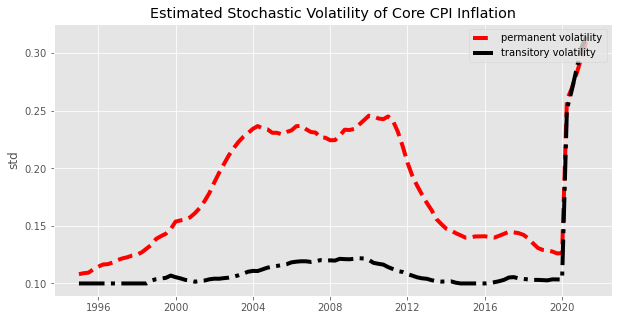

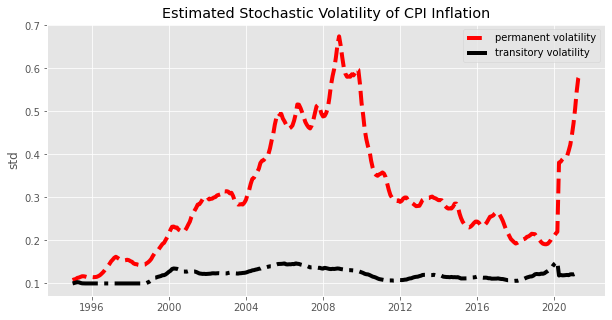

In [30]:
################
## quarterly ##
################

### quarterly data 
### exporting inflation series for process estimation using UCSV model in matlab

CPICQ.to_excel("../OtherData/CPICQ.xlsx")  ## this is for matlab estimation of UCSV model

################
## monthly ####
################

### process parameters estimation 

### exporting monthly inflation series for process estimation using UCSV model in matlab
CPIM.to_excel("../OtherData/CPIM.xlsx")  ## this is for matlab estimation of UCSV model

##########################################################################
##########################################################################
##########################################################################
## use matlab code stockwatson.m to estimate UCSV model before moving on!
##########################################################################
##########################################################################
##########################################################################
##########################################################################


## process parameters estimation for SV 

################
## quarterly ##
################

### import the estimated results 
CPICQ_UCSV_Est = pd.read_excel('../OtherData/UCSVestQ.xlsx')  
CPICQ_UCSV_Est.index = pd.to_datetime(CPICQ_UCSV_Est['date'],format='%Y%m%d')
CPICQ_UCSV_Est = CPICQ_UCSV_Est.drop(columns=['date'])
CPICQ_UCSV_Est = CPICQ_UCSV_Est.rename(columns = {'sd_eps':'sd_p_est',
                                      'sd_eta':'sd_t_est',
                                      'tau':'p'})  ## Loading ucsv model estimates 



################
## monthly ####
################

### import the estimated results 
CPIM_UCSV_Est = pd.read_excel('../OtherData/UCSVestM.xlsx')  
CPIM_UCSV_Est.index =pd.to_datetime(CPIM_UCSV_Est['date'],format='%Y%m%d')
CPIM_UCSV_Est = CPIM_UCSV_Est.drop(columns=['date'])
CPIM_UCSV_Est = CPIM_UCSV_Est.rename(columns = {'sd_eps':'sd_p_est',
                                                'sd_eta':'sd_t_est',
                                                'tau':'p'})  ## Loading ucsv model estimates 

########################################################################################
## be careful with the order, I define eta as the permanent and eps to be the transitory
 ######################################################################################
    

### quarterly plot 

plt.figure(figsize=(10,5))
plt.plot(CPICQ_UCSV_Est['sd_p_est'],
         'r--',
          lw = lw,
         label='permanent volatility')
plt.plot(CPICQ_UCSV_Est['sd_t_est'],
         'k-.',
         lw = lw,
         label='transitory volatility')
plt.title('Estimated Stochastic Volatility of Core CPI Inflation')
plt.ylabel('std')
plt.legend(loc=1)
plt.savefig('../graphs/inflation/UCSVQ.png')
    
### monthly plot 

plt.figure(figsize=(10,5))
plt.plot(CPIM_UCSV_Est['sd_p_est'],
         'r--',
          lw = lw,
         label='permanent volatility')
plt.plot(CPIM_UCSV_Est['sd_t_est'],
         'k-.',
         lw = lw,
         label='transitory volatility')
plt.title('Estimated Stochastic Volatility of CPI Inflation')
plt.ylabel('std')
plt.legend(loc=1)
plt.savefig('../graphs/inflation/UCSVM.png')

In [31]:
#########################################################
## specific to SV model  
######################################################

#############
## quarterly 
##############

n_burn_rt_historyQ = len(CPICQ_UCSV_Est) - len(historyQ)  

history_yQ = np.array(historyQ['RTCPICore'])
history_vol_pQ = np.array(CPICQ_UCSV_Est['sd_p_est'][n_burn_rt_historyQ:])**2  ## permanent
history_vol_tQ = np.array(CPICQ_UCSV_Est['sd_t_est'][n_burn_rt_historyQ:])**2 ## transitory

#history_volsQ = np.array([history_vol_pQ,
#                          history_vol_tQ])
history_pQ = np.array(CPICQ_UCSV_Est['p'][n_burn_rt_historyQ:])

## to burn 
n_burn_Q = len(history_pQ) - len(SPF_est['RTCPI'])
real_time_yQ = history_yQ[n_burn_Q:]
real_time_vol_pQ = history_vol_pQ[n_burn_Q:]
real_time_vol_tQ = history_vol_tQ[n_burn_Q:]
real_time_pQ = history_pQ[n_burn_Q:]

############
## monthly
############

n_burn_rt_historyM = len(CPIM_UCSV_Est) - len(historyM)  

history_yM = np.array(historyM['RTCPI'])
history_vol_pM = np.array(CPIM_UCSV_Est['sd_p_est'][n_burn_rt_historyM:])**2
history_vol_tM = np.array(CPIM_UCSV_Est['sd_t_est'][n_burn_rt_historyM:])**2

#history_volsM = np.array([history_vol_pM,
#                          history_vol_tM])  ## order is import 

history_pM = np.array(CPIM_UCSV_Est['p'][n_burn_rt_historyM:])

## to burn 
n_burn_M = len(history_pM) - len(SCE_est['RTCPI'])
real_time_yM = history_yM[n_burn_M:]
real_time_vol_pM = history_vol_pM[n_burn_M:]
real_time_vol_tM = history_vol_tM[n_burn_M:]
real_time_pM = history_pM[n_burn_M:]

In [32]:
## generate histories and real time array 

history_Q_sv = np.array([history_yQ,
                           history_pQ,
                           history_vol_pQ,
                           history_vol_tQ])
history_M_sv = np.array([history_yM,
                           history_pM,
                           history_vol_pM,
                           history_vol_tM])

real_time_Q_sv = np.array([real_time_yQ,
                         real_time_pQ,
                         real_time_vol_pQ,
                         real_time_vol_tQ])
real_time_M_sv = np.array([real_time_yM,
                         real_time_pM,
                         real_time_vol_pM,
                         real_time_vol_tM])

In [33]:
## process parameters 
process_paraQ_est_sv = np.array([0.2])
process_paraM_est_sv = np.array([0.2])

### Estimation 

In [34]:
agents_list = ['SPF',
               'SCE']

horizon_list = [4,
               12]

process_list = ['AR',
                'SV'
               ]

ex_model_list = ['SE',
                 'NI',
                 'DE',
                 'DENI'
                ]
nb_ex_model = len(ex_model_list)

moments_list = [['FE','FEVar','FEATV'],
               ['FE','FEVar','FEATV','Disg','DisgVar','DisgATV'],
               ['FE','FEVar','FEATV','Disg','DisgVar','DisgATV','Var','VarVar','VarATV']]

nb_moments = len(moments_list)

how_list =['2-step','Joint']

moments_list_general = ['FE','FE+Disg','FE+Disg+Var']

model_list = [sear0,
              niar0,
              dear0,
              deniar0,
              sesv0,
              nisv0,
              desv0,
              denisv0
]

algorithm_list = ['trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr'
                 ]


algorithm_joint_list = ['trust-constr',
                        'trust-constr',
                        'trust-constr',
                        'trust-constr',
                        None,
                        None,
                        None,
                        None
]

bns_list =[((0,1),),
           ((0,3),(0,3),),
           ((-2,2),(0,5),),
           ((-3,3),(0,3),),
           ((0,1),),
           ((0,3),(0,3),),
           ((-2,2),(0,np.inf),),
           ((-3,3),(0,3),)
]

bns_joint_list =[((0,1),(0.9,1),(0,np.inf),),
                 ((0,3),(0,3),(0.9,1),(0,np.inf),),
                 ((-2,2),(0,5),(0.9,1),(0,np.inf),),
                 ((-3,3),(0,3),(0.9,1),(0,np.inf),),
                 None,
                 None,
                 None,
                 None
]

data_mom_dict_list = [data_moms_dct_SPF,
                      data_moms_dct_SCE]

process_paras_list = [process_paraQ_est_ar,
                      process_paraQ_est_sv,
                      process_paraM_est_ar,
                      process_paraM_est_sv
]

realized_list = [realized_CPIC.astype(np.float64),
                 realized_CPI.astype(np.float64)]

real_time_list = [np.array(real_time_Q_ar),
                 np.array(real_time_Q_sv),  ## 4 x t array 
                np.array(real_time_M_ar),
                np.array(real_time_M_sv)
]  ## 4 x t array 

history_list = [np.array(history_Q_ar),
               np.array(history_Q_sv),     ## 4 x t array 
               np.array(history_M_ar), 
               np.array(history_M_sv)
]     ## 4 x t array 

## parameter guesses 
guesses_list = [np.array([0.2]),  ## se lbd 
               np.array([0.5,0.8]),  ## ni sigma_pb, sigma_pr
               np.array([0.3,0.4]),   ## de theta theta_sigma
               np.array([0.1,0.3])
               ]  ## deni theta, sigma_pb, sigma_pr

guesses_joint_list = [np.array([0.2,0.98,0.1]),            ## se lbd 
                     np.array([0.1,0.2,0.95,0.1]),      ## ni sigma_pb, sigma_pr
                     np.array([0.3,0.4,0.95,0.1]),      ## de theta theta_sigma
                     np.array([0.1,0.3,0.95,0.1]),  ## theta, sigma_pb, sigma_pr  
                       ## for sv models not used
                      np.array([0.3,0.2]),            ## se lbd 
                      np.array([0.1,0.2,0.2]),      ## ni sigma_pb, sigma_pr
                       np.array([0.3,0.2]),      ## de theta theta_sigma
                       np.array([0.1,0.2])
                     ]  ## deni theta, sigma_pb, sigma_pr]

n_exp_paras_list = [1,
                    2,
                    2,
                    2]


## names labels 

se_ar_names = [r'$\hat\lambda$',
                   r'$\rho$',
                   r'$\sigma$',
                   r'$\hat\lambda$', 
                   r'$\rho$',
                   r'$\sigma$']


ni_ar_names = [r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{pr}$',
                   r'$\rho$',
                   r'$\sigma$',
                   r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{pr}$',
                   r'NI: $\rho$',
                   r'NI: $\sigma$']


de_ar_names = [r'$\hat\theta$',
                   r'$\sigma_\theta$',
                   r'$\rho$',
                   r'$\sigma$',
                   r'$\hat\theta$',
                   r'$\sigma_\theta$',
                   r'$\rho$',
                   r'$\sigma$']


deni_ar_names = [r'$\hat\theta$',
                  # r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{pr}$',
                   r'$\rho$',
                   r'$\sigma$',
                   r'$\hat\theta$',
                  # r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{pr}$',
                   r'$\rho$',
                   r'$\sigma$']

se_sv_names = [r'$\hat\lambda$',
               r'$\gamma$']


ni_sv_names = [r'$\hat\sigma_{pb}$',
               r'$\hat\sigma_{pr}$',
               r'$\gamma$']


de_sv_names = [r'$\hat\theta$',
               r'$\sigma_\theta$',                   
               r'$\gamma$']


deni_sv_names = [r'$\hat\theta$',
                  # r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{pr}$',
                   r'$\gamma$']


names_list = [se_ar_names,
             ni_ar_names,
             de_ar_names,
             deni_ar_names,
             se_sv_names,
             ni_sv_names,
             de_sv_names,
             deni_sv_names]

################################################################################
## A loop to estimate the model for different agents, theory, inflation process and joint/2-step 
#################################################################################

paras_list = []
paras_step2_list = []
paras_joint_list = []
paras_joint_step2_list = []

for agent_id,agent in enumerate(agents_list):
    print(agent)
    realized_this = realized_list[agent_id]
    data_mom_dict_this = data_mom_dict_list[agent_id]
    for pg_id,process in enumerate(process_list):
        print(process)
        ## history and real-time inflation that is fed in the model depends on agent type and process
        agent_process_id = agent_id*2+pg_id       
        process_paras_this = process_paras_list[agent_process_id]
        real_time_this = real_time_list[agent_process_id]
        history_this = history_list[agent_process_id] 
        
        for exp_id,ex_model in enumerate(ex_model_list):
            print(ex_model)
            model_idx  = pg_id*nb_ex_model+exp_id
            print(model_idx)
            model_instance = model_list[model_idx]
            alg_this= algorithm_list[model_idx]
            bounds_this = bns_list[model_idx]
            print('2-step estimation uses algorithm'+alg_this)
            print('bounds for parameters'+str(bounds_this))
            alg_joint_this= algorithm_joint_list[model_idx]
            bounds_joint_this = bns_joint_list[model_idx]
            names_this = names_list[model_idx]

            ## feed inputs to the instance 
            instance = model_instance

            print(instance)
            print('horizon', horizon_list[agent_id])
            instance.horizon = horizon_list[agent_id]
            
            instance.GetRealization(realized_this)
            instance.real_time = real_time_this
            instance.history = history_this
            instance.process_para = process_paras_this 
            
            ## model-specific estimates holder 
            
            paras_list_this_model = []
            paras_step2_list_this_model = []
            paras_joint_list_this_model = []
            paras_joint_step2_list_this_model = []
            
            ## specific objetive function to minimize (only for expectation)

            for mom_id, moments_this in enumerate(moments_list):
                print(moments_this)
                print('Step 1')
                def Obj_this(paras_this):  
                    scalor = ObjGen(instance,
                                    paras = paras_this,
                                    data_mom_dict = data_mom_dict_this,
                                    moment_choice = List(moments_this),
                                    how ='expectation')
                    return scalor
                
                guess_this = guesses_list[exp_id]
                ## estimating
                para_est  = ParaEst(Obj_this,
                                 para_guess = guess_this,
                                 method= alg_this,
                                bounds = bounds_this)
                
                ## try it another time if no convergence 
                if np.isnan(para_est).any()==True:
                    para_est  = ParaEst(Obj_this,
                                 para_guess = guess_this,
                                 method= alg_this,
                                bounds = bounds_this)
                    
                ## same para est
                if np.isnan(para_est).any()==False:
                    
                    ## compute the efficient weighting matrix 
                    instance.exp_para = para_est
                    smm_dict_this = instance.SMM()
                    distance = np.array([smm_dict_this[mom] - data_mom_dict_this[mom] for mom in moments_this]) 
                    distance_diag = np.diag(distance*distance.T)
                    wm1st = np.linalg.inv(distance_diag)

                    ## 2-step estimation using efficient matrix 
                    def Obj_this_step2(paras_this):
                        scalor = ObjWeight(instance,
                                           paras = paras_this,
                                           weight = wm1st,
                                           data_mom_dict = data_mom_dict_this,
                                           moment_choice = List(moments_this),
                                           how ='expectation')
                        return scalor
                    para_est_step2  = ParaEst(Obj_this_step2,
                                        para_guess = guess_this,
                                        method= alg_this,
                                        bounds = bounds_this)
                    if np.isnan(para_est_step2).any()==True:
                        print('the 2-step estimation is nan')
                        para_est_step2_nan = np.array([np.nan])
                        para_est_step2 = para_est_step2_nan
                else:
                    print('the estimation is nan')
                    para_est_nan = np.array([np.nan])
                    para_est = para_est_nan
                                        
                    para_est_step2_nan = np.array([np.nan])
                    para_est_step2 = para_est_step2_nan
                    
                ## save para est
                
                para_est = np.round(para_est,2)
                print('Step 1:'+str(para_est))
                paras_list_this_model.append(para_est)
                paras_list.append(para_est)
                
                para_est_step2 = np.round(para_est_step2,2)
                print('Step 2:'+str(para_est_step2))
                paras_step2_list_this_model.append(para_est_step2)
                paras_step2_list.append(para_est_step2)
                
                
                ##  joint estimation 
                n_exp_paras_this = n_exp_paras_list[exp_id]
                
                moments_this_ = List(moments_this+['InfAV','InfVar','InfATV']) ## added inflation moments 
                
                if pg_id <=0: ## no joint estimation for SV models 
                    def Obj_joint_this(paras):
                        scalor = ObjGen(instance,
                                        paras = paras,
                                        data_mom_dict = data_mom_dict_this,
                                        moment_choice = moments_this_,
                                        how = 'joint',
                                        n_exp_paras = n_exp_paras_this)
                        return scalor

                    guess_this_ = guesses_joint_list[model_idx]
                    ## estimating
                    paras_joint_est = ParaEst(Obj_joint_this,
                                              para_guess = guess_this_,
                                              method= alg_joint_this,
                                              bounds = bounds_joint_this) ##Nelder-Mead  
                    if  np.isnan(paras_joint_est).any()==False:
                        ## compute the efficient weighting matrix 
                        instance.exp_para = paras_joint_est[0:n_exp_paras_this]     
                        instance.process_para = paras_joint_est[n_exp_paras_this:]
                        smm_dict_this = instance.SMM()
                        distance = np.array([smm_dict_this[mom] - data_mom_dict_this[mom] for mom in moments_this_]) 
                        distance_diag = np.diag(distance*distance.T)
                        wm1st = np.linalg.inv(distance_diag)

                        ## 2-step estimation using efficient matrix 
                        def Obj_joint_this_step2(paras_this):
                            scalor = ObjWeight(instance,
                                               paras = paras_this,
                                               weight = wm1st,
                                               data_mom_dict = data_mom_dict_this,
                                               moment_choice = moments_this_,
                                               how ='joint',
                                               n_exp_paras = n_exp_paras_this)
                            return scalor
                        ## re-estimating
                        para_est_joint_step2  = ParaEst(Obj_joint_this_step2,
                                                        para_guess = guess_this_,
                                                        method = alg_joint_this,
                                                        bounds = bounds_joint_this)     #  Nelder-Mead
                        if np.isnan(para_est_joint_step2).any()==True:
                            print('the 2-step estimation is nan')
                            para_est_joint_step2 = np.array([np.nan])
                        
                    else:
                        print('the estimation is nan')
                        paras_joint_est = np.array([np.nan])
                        para_est_joint_step2 = np.array([np.nan])
                
                else:
                    paras_joint_est = np.array([np.nan])
                    para_est_joint_step2 = np.array([np.nan])
                
                ## save in the list 
                paras_joint_est = np.round(paras_joint_est,2)
                print('Step 1:'+str(paras_joint_est))
                paras_joint_list_this_model.append(paras_joint_est)
                paras_joint_list.append(paras_joint_est)
                
                para_est_joint_step2 = np.round(para_est_joint_step2,2)
                print('Step 2:'+str(para_est_joint_step2))
                paras_joint_step2_list_this_model.append(para_est_joint_step2)
                paras_joint_step2_list.append(para_est_joint_step2)
            
            
            ### export model-specific estimates 
            names = names_list[model_idx]
            #print(paras_step2_list_this_model)
            #print(paras_joint_step2_list_this_model)
            para_est_tab_this_model = pd.DataFrame(paras_step2_list_this_model,
                                            index = moments_list_general)
            para_est_process_tab_this_model = pd.DataFrame([process_paras_this]*nb_moments,
                                            index = moments_list_general)
            para_joint_est_tab_this_model = pd.DataFrame(paras_joint_step2_list_this_model,
                                            index = moments_list_general)
            para_all_est_tab_this_model = pd.concat([para_est_tab_this_model,
                                                     para_est_process_tab_this_model,
                                                     para_joint_est_tab_this_model],
                                                    join = 'inner', axis=1)
            print(names_this)
            try:
                para_all_est_tab_this_model.columns = names_this 
            except:
                pass
            para_all_est_tab_this_model.to_excel('tables/'+agent+'_'+process+'_'+ex_model+'.xlsx',
                                       float_format='%.2f',
                                       index = True)

SPF
AR
SE
0
2-step estimation uses algorithmtrust-constr
bounds for parameters((0, 1),)
horizon 4
['FE', 'FEVar', 'FEATV']
Step 1


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.039 s.


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.034 s.
Step 1:[0.36]
Step 2:[0.36]
`gtol` termination condition is satisfied.
Number of iterations: 36, function evaluations: 116, CG iterations: 43, optimality: 7.76e-09, constraint violation: 0.00e+00, execution time: 0.51 s.


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 42, function evaluations: 136, CG iterations: 91, optimality: 6.88e-09, constraint violation: 0.00e+00, execution time: 0.66 s.
Step 1:[0.51 0.99 0.04]
Step 2:[0.19 1.   0.02]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.035 s.
`gtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 110, CG iterations: 52, optimality: 7.26e-09, constraint violation: 0.00e+00, execution time: 0.53 s.
Step 1:[0.36]
Step 2:[0.26]
`gtol` termination condition is satisfied.
Number of iterations: 135, function evaluations: 652, CG iterations: 168, optimality: 6.80e-09, constraint violation: 0.00e+00, execution time:  2.7 s.
`xtol` termination condition is satisfied.
Number of iterations: 130, function evaluations

/Users/tao/Dropbox/InfVar/workingfolder/python/SMMEst.py:215: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  model_mom_dict = model.SMM()


`gtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 72, CG iterations: 36, optimality: 5.72e-10, constraint violation: 0.00e+00, execution time:  3.6 s.
`gtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 69, CG iterations: 36, optimality: 8.36e-10, constraint violation: 0.00e+00, execution time:  3.3 s.
Step 1:[2.93 0.  ]
Step 2:[3.   0.08]
`gtol` termination condition is satisfied.
Number of iterations: 41, function evaluations: 155, CG iterations: 92, optimality: 2.25e-09, constraint violation: 0.00e+00, execution time:  7.5 s.
`xtol` termination condition is satisfied.
Number of iterations: 152, function evaluations: 1015, CG iterations: 405, optimality: 6.48e-07, constraint violation: 0.00e+00, execution time: 5e+01 s.
Step 1:[0.   0.23 0.99 0.04]
Step 2:[0.   0.21 0.99 0.04]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 23,

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 130, function evaluations: 354, CG iterations: 193, optimality: 5.25e-02, constraint violation: 0.00e+00, execution time: 1.8e+01 s.
Step 1:[0.   0.82]
Step 2:[0.03 0.85]
`gtol` termination condition is satisfied.
Number of iterations: 43, function evaluations: 170, CG iterations: 101, optimality: 8.48e-09, constraint violation: 0.00e+00, execution time:  8.3 s.
`xtol` termination condition is satisfied.
Number of iterations: 133, function evaluations: 775, CG iterations: 338, optimality: 9.30e-08, constraint violation: 0.00e+00, execution time: 4e+01 s.
Step 1:[0.   0.18 0.99 0.04]
Step 2:[0.   0.19 0.99 0.04]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar', 'VarATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 23, function evaluations: 39, CG iterations: 21, optimality: 2.82e-09, constraint violation: 0.00e+00, execution time:  1.8 s.
`xtol` termination condition is sat

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 285, CG iterations: 105, optimality: 3.88e-06, constraint violation: 0.00e+00, execution time: 0.11 s.
Step 1:[0.27 1.45]
Step 2:[0.38 0.47]
`gtol` termination condition is satisfied.
Number of iterations: 44, function evaluations: 170, CG iterations: 95, optimality: 6.58e-09, constraint violation: 0.00e+00, execution time: 0.099 s.
`xtol` termination condition is satisfied.
Number of iterations: 94, function evaluations: 610, CG iterations: 226, optimality: 1.39e-05, constraint violation: 0.00e+00, execution time: 0.18 s.
Step 1:[0.52 0.75 0.98 0.05]
Step 2:[0.71 0.4  0.98 0.05]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 55, function evaluations: 123, CG iterations: 73, optimality: 6.82e-09, constraint violation: 0.00e+00, execution time: 0.084 s.
`xtol` termination condition is satisfied.
Number of iterations: 6

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 49, function evaluations: 200, CG iterations: 102, optimality: 6.15e-09, constraint violation: 0.00e+00, execution time: 0.12 s.
`xtol` termination condition is satisfied.
Number of iterations: 129, function evaluations: 820, CG iterations: 354, optimality: 6.62e-06, constraint violation: 0.00e+00, execution time: 0.28 s.
Step 1:[0.53 2.13 0.98 0.05]
Step 2:[0.69 2.17 0.98 0.05]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar', 'VarATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 45, CG iterations: 17, optimality: 6.22e-09, constraint violation: 0.00e+00, execution time: 0.046 s.
`xtol` termination condition is satisfied.
Number of iterations: 72, function evaluations: 210, CG iterations: 99, optimality: 8.90e-06, constraint violation: 0.00e+00, execution time: 0.11 s.
Step 1:[0.54 2.13]
Step 2:[0.69 2.17]
`gtol` termination condition is satisfie

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 169, function evaluations: 430, CG iterations: 231, optimality: 1.42e-02, constraint violation: 0.00e+00, execution time:  1.2 s.
`xtol` termination condition is satisfied.
Number of iterations: 141, function evaluations: 870, CG iterations: 319, optimality: 1.22e-06, constraint violation: 0.00e+00, execution time:  2.3 s.
Step 1:[0.22 0.15 0.98 0.05]
Step 2:[0.77 0.   0.99 0.05]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 39, function evaluations: 93, CG iterations: 49, optimality: 7.00e-09, constraint violation: 0.00e+00, execution time: 0.29 s.


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 390, function evaluations: 1350, CG iterations: 714, optimality: 3.32e-02, constraint violation: 0.00e+00, execution time:  3.9 s.
Step 1:[0.8  0.15]
Step 2:[0.86 0.12]
`gtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 235, CG iterations: 127, optimality: 6.44e-09, constraint violation: 0.00e+00, execution time: 0.66 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 30, CG iterations: 5993, optimality: 9.23e+05, constraint violation: 0.00e+00, execution time:  1.4 s.
the 2-step estimation is nan
Step 1:[0.8  0.15 0.98 0.05]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar', 'VarATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 63, CG iterations: 31, optimality: 9.49e-09, constraint violation: 0.00e+00, execution time:  0.2 s.
`xtol` term

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.039 s.


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 12, CG iterations: 5, optimality: 6.40e-09, constraint violation: 0.00e+00, execution time: 0.074 s.
Step 1:[0.36]
Step 2:[0.33]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.041 s.
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.043 s.
Step 1:[0.36]
Step 2:[0.36]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar', 'VarATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, e

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 90, CG iterations: 69, optimality: 2.05e-08, constraint violation: 0.00e+00, execution time: 0.16 s.


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 105, CG iterations: 70, optimality: 5.88e-07, constraint violation: 0.00e+00, execution time: 0.19 s.
Step 1:[0.08 1.71]
Step 2:[0.24 0.45]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 135, CG iterations: 49, optimality: 9.98e-09, constraint violation: 0.00e+00, execution time: 0.22 s.
`xtol` termination condition is satisfied.
Number of iterations: 105, function evaluations: 378, CG iterations: 125, optimality: 8.22e-04, constraint violation: 0.00e+00, execution time: 0.55 s.
Step 1:[0.08 1.31]
Step 2:[0.25 1.31]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar', 'VarATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 48, CG iterations: 21, optimality: 6.75e-09, cons

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 123, function evaluations: 21, CG iterations: 114, optimality: 1.16e+01, constraint violation: 0.00e+00, execution time:  2.6 s.
Step 1:[1.18 1.92]
Step 2:[0.78 1.25]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar', 'VarATV']
Step 1
`xtol` termination condition is satisfied.
Number of iterations: 104, function evaluations: 51, CG iterations: 178, optimality: 5.78e-03, constraint violation: 0.00e+00, execution time:  7.1 s.
`xtol` termination condition is satisfied.
Number of iterations: 135, function evaluations: 168, CG iterations: 142, optimality: 4.70e+00, constraint violation: 0.00e+00, execution time: 2.5e+01 s.
Step 1:[0.99 1.68]
Step 2:[0.8 0.5]
Step 1:[nan]
Step 2:[nan]
['$\\hat\\theta$', '$\\hat\\sigma_{pr}$', '$\\gamma$']
SCE
AR
SE
0
2-step estimation uses algorithmtrust-constr
bounds for parameters((0, 1),)
horizon 12
['FE', 'FEVar', 'FEATV']
Step 1


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.17 s.
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.16 s.
Step 1:[0.36]
Step 2:[0.36]
`xtol` termination condition is satisfied.
Number of iterations: 332, function evaluations: 1484, CG iterations: 848, optimality: 4.89e-08, constraint violation: 0.00e+00, execution time: 5.2e+01 s.
`xtol` termination condition is satisfied.
Number of iterations: 282, function evaluations: 1628, CG iterations: 518, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time: 6e+01 s.
Step 1:[0.2 1.  0. ]
Step 2:[0.16 1.   0.04]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 70, function evaluations: 240, CG iterations: 74, optimality: 2.33e-08, constraint violation: 0.00e+00, execution time: 3.8e+01 s.
Step 1:[3. 3.]
Step 2:[3.   0.14]
`xtol` termination condition is satisfied.
Number of iterations: 869, function evaluations: 5175, CG iterations: 1410, optimality: 3.53e-05, constraint violation: 0.00e+00, execution time: 8.2e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 452, function evaluations: 3135, CG iterations: 989, optimality: 4.30e-03, constraint violation: 0.00e+00, execution time: 5.1e+02 s.
Step 1:[2.78 2.94 1.   0.  ]
Step 2:[2.8  3.   1.   0.01]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar', 'VarATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 19, function evaluations: 39, CG iterations: 14, optimality: 2.02e-09, constraint violation: 0.00e+00, execution time:  5.9 s.
`gtol` termination condition is 

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 332, function evaluations: 2190, CG iterations: 906, optimality: 7.42e-07, constraint violation: 0.00e+00, execution time:  1.3 s.
`xtol` termination condition is satisfied.
Number of iterations: 144, function evaluations: 935, CG iterations: 436, optimality: 7.34e-05, constraint violation: 0.00e+00, execution time: 0.54 s.
Step 1:[-0.99  1.87  1.    0.  ]
Step 2:[-0.66  0.44  0.99  0.09]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 60, CG iterations: 24, optimality: 9.51e-09, constraint violation: 0.00e+00, execution time: 0.064 s.
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 180, CG iterations: 114, optimality: 1.26e-06, constraint violation: 0.00e+00, execution time: 0.18 s.
Step 1:[-0.86  2.72]
Step 2:[-0.6   1.94]
The maximum number of function evaluations is exceed

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/qp_subproblem.py:573: RuntimeWarning: invalid value encountered in double_scalars
  alpha = rt_g / pt_H_p
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:53: RuntimeWarning: invalid value encountered in double_scalars
  orth = norm_A_g / (norm_A*norm_g)


`xtol` termination condition is satisfied.
Number of iterations: 105, function evaluations: 66, CG iterations: 184, optimality: 9.47e-03, constraint violation: 0.00e+00, execution time: 0.81 s.


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 186, function evaluations: 564, CG iterations: 302, optimality: 6.90e-09, constraint violation: 0.00e+00, execution time:  6.8 s.
Step 1:[0.08 0.4 ]
Step 2:[-0.37  2.14]
`xtol` termination condition is satisfied.
Number of iterations: 189, function evaluations: 425, CG iterations: 386, optimality: 2.26e-01, constraint violation: 0.00e+00, execution time:  5.1 s.


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 520, CG iterations: 5991, optimality: 5.20e+01, constraint violation: 0.00e+00, execution time:  7.2 s.
the 2-step estimation is nan
Step 1:[-0.76  1.98  1.    0.05]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 168, CG iterations: 77, optimality: 1.29e-09, constraint violation: 0.00e+00, execution time:  2.0 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 4530, CG iterations: 2702, optimality: 7.12e-02, constraint violation: 0.00e+00, execution time: 2.2e+03 s.
the 2-step estimation is nan
Step 1:[0.18 1.77]
Step 2:[nan]
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 7510, CG iterations: 3132, optimality: 1.53e-01, constraint violation: 0.00e+00

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.15 s.
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.15 s.
Step 1:[0.36]
Step 2:[0.36]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.15 s.
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.15 s.
Step 1:[0.36]
Step 2:[0.36]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar'

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 100, function evaluations: 294, CG iterations: 88, optimality: 1.02e-06, constraint violation: 0.00e+00, execution time: 6.2e+01 s.
Step 1:[0.63 0.04]
Step 2:[0.66 0.05]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 90, CG iterations: 21, optimality: 3.21e-09, constraint violation: 0.00e+00, execution time: 1.9e+01 s.
`xtol` termination condition is satisfied.
Number of iterations: 100, function evaluations: 351, CG iterations: 90, optimality: 8.69e-07, constraint violation: 0.00e+00, execution time: 7.5e+01 s.
Step 1:[0.65 0.04]
Step 2:[0.77 0.05]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar', 'VarATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 84, CG iterations: 21, optimality: 3.16e-

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 186, CG iterations: 81, optimality: 1.99e-07, constraint violation: 0.00e+00, execution time:  1.5 s.
Step 1:[-0.12  0.85]
Step 2:[-0.06  0.56]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`xtol` termination condition is satisfied.
Number of iterations: 60, function evaluations: 138, CG iterations: 72, optimality: 7.62e-08, constraint violation: 0.00e+00, execution time:  1.1 s.
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 297, CG iterations: 102, optimality: 1.51e-05, constraint violation: 0.00e+00, execution time:  2.4 s.
Step 1:[-0.12  0.87]
Step 2:[-0.06  0.85]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar', 'VarATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 78, CG iterations: 35, optimality: 7.80e-0

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:53: RuntimeWarning: invalid value encountered in double_scalars
  orth = norm_A_g / (norm_A*norm_g)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/qp_subproblem.py:573: RuntimeWarning: invalid value encountered in double_scalars
  alpha = rt_g / pt_H_p


`xtol` termination condition is satisfied.
Number of iterations: 114, function evaluations: 12, CG iterations: 112, optimality: 3.61e-02, constraint violation: 0.00e+00, execution time:  4.0 s.


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 12, CG iterations: 2997, optimality: 1.21e+00, constraint violation: 0.00e+00, execution time:  4.6 s.
the 2-step estimation is nan
Step 1:[0.03 0.41]
Step 2:[nan]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 15, CG iterations: 2994, optimality: 2.22e-02, constraint violation: 0.00e+00, execution time:  6.0 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 15, CG iterations: 2994, optimality: 2.22e-02, constraint violation: 0.00e+00, execution time:  5.9 s.
the estimation is nan
Step 1:[nan]
Step 2:[nan]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV', 'Var', 'VarVar', 'VarATV']
Step 1
The maximum number of function evaluations is exceeded.
Numbe

In [35]:
## an example of para est list 
paras_joint_list

[array([0.51, 0.99, 0.04]),
 array([0.31, 0.99, 0.03]),
 array([0.5 , 0.99, 0.04]),
 array([0.  , 0.23, 0.99, 0.04]),
 array([0.  , 0.18, 0.99, 0.04]),
 array([0.  , 0.2 , 0.98, 0.05]),
 array([0.52, 0.75, 0.98, 0.05]),
 array([0.53, 2.13, 0.98, 0.05]),
 array([0.72, 2.15, 0.98, 0.06]),
 array([0.22, 0.15, 0.98, 0.05]),
 array([0.8 , 0.15, 0.98, 0.05]),
 array([0.8 , 0.15, 0.98, 0.06]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([0.2, 1. , 0. ]),
 array([0.2 , 0.98, 0.1 ]),
 array([0.2 , 0.98, 0.1 ]),
 array([nan]),
 array([2.78, 2.94, 1.  , 0.  ]),
 array([2.96, 2.97, 1.  , 0.  ]),
 array([-0.99,  1.87,  1.  ,  0.  ]),
 array([nan]),
 array([nan]),
 array([-0.76,  1.98,  1.  ,  0.05]),
 array([nan]),
 array([0.58, 0.77, 0.98, 0.18]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array

In [117]:
## create multiple index to store coefficient estimates 

iterables = [agents_list, process_list, ex_model_list,moments_list_general]
midx = pd.MultiIndex.from_product(iterables, names=['Agents', 'Process','Model','Moments'])
paras_table = pd.DataFrame(index = midx)

## 2-step table
paras_list = [tuple(paras) for paras in paras_list]
paras_table['ParaEst'] = paras_list

paras_step2_list = [tuple(paras) for paras in paras_step2_list]
paras_table['ParaEst2step'] = paras_step2_list

## joint table
paras_joint_table = pd.DataFrame(index = midx)

paras_joint_list = [tuple(paras) for paras in paras_joint_list]
paras_joint_table['ParaEst'] = paras_joint_list

paras_joint_step2_list = [tuple(paras) for paras in paras_joint_step2_list]
paras_joint_table['ParaEst2step'] = paras_joint_step2_list


In [37]:
paras_table.columns = [['2-step Estimate','2-step Estimate 2nd step']]
paras_joint_table.columns = [['Joint Estimate','Joint Estimate 2nd step']]

In [38]:
paras_combine_table = pd.merge(paras_table,
                               paras_joint_table,
                               how='outer',
                               left_index=True,
                               right_index=True)

In [39]:
print(process_paraQ_est_ar)
print(process_paraM_est_ar)

[0.9898447  0.22568422]
[0.98494897 0.40642153]


In [40]:
paras_combine_table

2-step Estimate 2-step Estimate 2nd step  \
Agents Process Model Moments                                                
SPF    AR      SE    FE                  (0.36,)                  (0.36,)   
                     FE+Disg             (0.36,)                  (0.26,)   
                     FE+Disg+Var         (0.36,)                  (0.36,)   
               NI    FE              (2.93, 0.0)              (3.0, 0.08)   
                     FE+Disg         (0.0, 0.82)             (0.03, 0.85)   
                     FE+Disg+Var     (0.0, 0.84)             (0.03, 0.85)   
               DE    FE             (0.27, 1.45)             (0.38, 0.47)   
                     FE+Disg        (0.55, 2.13)             (0.73, 2.17)   
                     FE+Disg+Var    (0.54, 2.13)             (0.69, 2.17)   
               DENI  FE             (0.74, 0.15)             (0.62, 0.42)   
                     FE+Disg         (0.8, 0.15)             (0.86, 0.12)   
                     FE+Disg+Var    (0.83, 0.17)             (0.87, 0.15)   
       SV      SE    FE                  (0.36,)                  (0.33,)   
                     FE+Disg             (0.36,)                  (0.36,)   
                     FE+Disg+Var         (0.36,)                  (0.36,)   
               NI    FE              (2.13, 3.0)              (2.94, 3.0)   
                     FE+Disg        (1.86, 2.98)              (2.94, 3.0)   
                     FE+Disg+Var     (1.83, 3.0)              (2.57, 3.0)   
               DE    FE             (0.08, 1.71)             (0.24, 0.45)   
                     FE+Disg        (0.08, 1.31)             (0.25, 1.31)   
                     FE+Disg+Var    (0.08, 1.31)             (0.25, 1.31)   
               DENI  FE             (1.18, 2.16)             (1.08, 1.31)   
                     FE+Disg        (1.18, 1.92)             (0.78, 1.25)   
                     FE+Disg+Var    (0.99, 1.68)               (0.8, 0.5)   
SCE    AR      SE    FE                  (0.36,)                  (0.36,)   
                     FE+Disg             (0.36,)                  (0.28,)   
                     FE+Disg+Var         (0.36,)                  (0.36,)   
               NI    FE             (1.69, 1.99)               (3.0, 1.3)   
                     FE+Disg          (3.0, 3.0)              (3.0, 0.14)   
                     FE+Disg+Var      (3.0, 3.0)              (1.41, 3.0)   
               DE    FE            (-0.34, 2.07)              (0.2, 0.59)   
                     FE+Disg       (-0.86, 2.72)             (-0.6, 1.94)   
                     FE+Disg+Var    (0.21, 3.31)             (0.61, 2.36)   
               DENI  FE              (0.08, 0.4)            (-0.37, 2.14)   
                     FE+Disg        (0.18, 1.77)                   (nan,)   
                     FE+Disg+Var     (-0.5, 3.0)            (-0.28, 2.36)   
       SV      SE    FE                  (0.36,)                  (0.36,)   
                     FE+Disg             (0.36,)                  (0.36,)   
                     FE+Disg+Var         (0.36,)                  (0.36,)   
               NI    FE             (0.63, 0.04)             (0.66, 0.05)   
                     FE+Disg        (0.65, 0.04)             (0.77, 0.05)   
                     FE+Disg+Var    (0.69, 0.04)             (0.66, 0.05)   
               DE    FE            (-0.12, 0.85)            (-0.06, 0.56)   
                     FE+Disg       (-0.12, 0.87)            (-0.06, 0.85)   
                     FE+Disg+Var   (-0.12, 0.87)            (-0.06, 0.85)   
               DENI  FE             (0.03, 0.41)                   (nan,)   
                     FE+Disg              (nan,)                   (nan,)   
                     FE+Disg+Var          (nan,)                   (nan,)   

                                            Joint Estimate  \
Agents Process Model Moments                                 
SPF    AR      SE    FE                 (0.51, 0.99, 0.04)

In [41]:
## only 2nd-step estimates 

paras_combine_table_2step = paras_combine_table[['2-step Estimate 2nd step','Joint Estimate 2nd step']]

paras_combine_table_2step

2-step Estimate 2nd step  \
Agents Process Model Moments                                
SPF    AR      SE    FE                           (0.36,)   
                     FE+Disg                      (0.26,)   
                     FE+Disg+Var                  (0.36,)   
               NI    FE                       (3.0, 0.08)   
                     FE+Disg                 (0.03, 0.85)   
                     FE+Disg+Var             (0.03, 0.85)   
               DE    FE                      (0.38, 0.47)   
                     FE+Disg                 (0.73, 2.17)   
                     FE+Disg+Var             (0.69, 2.17)   
               DENI  FE                      (0.62, 0.42)   
                     FE+Disg                 (0.86, 0.12)   
                     FE+Disg+Var             (0.87, 0.15)   
       SV      SE    FE                           (0.33,)   
                     FE+Disg                      (0.36,)   
                     FE+Disg+Var                  (0.36,)   
               NI    FE                       (2.94, 3.0)   
                     FE+Disg                  (2.94, 3.0)   
                     FE+Disg+Var              (2.57, 3.0)   
               DE    FE                      (0.24, 0.45)   
                     FE+Disg                 (0.25, 1.31)   
                     FE+Disg+Var             (0.25, 1.31)   
               DENI  FE                      (1.08, 1.31)   
                     FE+Disg                 (0.78, 1.25)   
                     FE+Disg+Var               (0.8, 0.5)   
SCE    AR      SE    FE                           (0.36,)   
                     FE+Disg                      (0.28,)   
                     FE+Disg+Var                  (0.36,)   
               NI    FE                        (3.0, 1.3)   
                     FE+Disg                  (3.0, 0.14)   
                     FE+Disg+Var              (1.41, 3.0)   
               DE    FE                       (0.2, 0.59)   
                     FE+Disg                 (-0.6, 1.94)   
                     FE+Disg+Var             (0.61, 2.36)   
               DENI  FE                     (-0.37, 2.14)   
                     FE+Disg                       (nan,)   
                     FE+Disg+Var            (-0.28, 2.36)   
       SV      SE    FE                           (0.36,)   
                     FE+Disg                      (0.36,)   
                     FE+Disg+Var                  (0.36,)   
               NI    FE                      (0.66, 0.05)   
                     FE+Disg                 (0.77, 0.05)   
                     FE+Disg+Var             (0.66, 0.05)   
               DE    FE                     (-0.06, 0.56)   
                     FE+Disg                (-0.06, 0.85)   
                     FE+Disg+Var            (-0.06, 0.85)   
               DENI  FE                            (nan,)   
                     FE+Disg                       (nan,)   
                     FE+Disg+Var                   (nan,)   

                                    Joint Estimate 2nd step  
Agents Process Model Moments                                 
SPF    AR      SE    FE                   (0.19, 1.0, 0.02)  
                     FE+Disg               (0.2, 0.98, 0.1)  
                     FE+Disg+Var           (0.2, 0.98, 0.1)  
               NI    FE             (0.0, 0.21, 0.99, 0.04)  
                     FE+Disg        (0.0, 0.19, 0.99, 0.04)  
                     FE+Disg+Var    (0.0, 0.19, 0.99, 0.05)  
               DE    FE             (0.71, 0.4, 0.98, 0.05)  
                     FE+Disg       (0.69, 2.17, 0.98, 0.05)  
                     FE+Disg+Var                     (nan,)  
               DENI  FE             (0.77, 0.0, 0.99, 0.05)  
                     FE+Disg                         (nan,)  
                     FE+Disg+Var                     (nan,)  
       SV      SE    FE                              (nan,)  
                     FE+Disg                        

In [42]:
## Flag those under-identified cases 

ui_list = [('SPF','AR','NI','FE'),
          ('SCE','AR','NI','FE'),
          ('SPF','AR','DENI','FE'),
          ('SCE','AR','DENI','FE'),
          ('SPF','SV','NI','FE'),
          ('SCE','SV','NI','FE'),
          ('SPF','SV','DENI','FE'),
          ('SCE','SV','DENI','FE')
          ]


for case in ui_list:
    print(case)
    for name in paras_combine_table.columns:
        print(name)
        paras_combine_table.loc[case,name]= tuple(np.array([]))
        #paras_combine_table.loc[case][name] = tuple(np.array([]))

('SPF', 'AR', 'NI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SCE', 'AR', 'NI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SPF', 'AR', 'DENI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SCE', 'AR', 'DENI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SPF', 'SV', 'NI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SCE', 'SV', 'NI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SPF', 'SV', 'DENI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SCE', 'SV', 'DENI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estim

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_15885/2813330448.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  paras_combine_table.loc[case,name]= tuple(np.array([]))


In [43]:
t_sim = 500
t_burn = 30

def simulate_history(pg_para,
                     t_sim,
                     t_burn):
    if len(pg_para)==2:
        ρ,σ = pg_para
        history_this = SimAR1(ρ,
                              σ,
                              t_sim)
        real_time_this = history_this[t_burn:-2] 
        realized_this = history_this[t_burn+1:-1]
        
    elif len(pg_para)==1:
        γ_fake = pg_para[0]
        
        
        history_this,p_history_this,vol_p_history_this,vol_t_history_this = SimUCSV(γ_fake,
                                                                                    nobs = t_sim,
                                                                                    p0 = p0_fake) 
        history_this =  np.array([history_this,
                                p_history_this,
                                vol_p_history_this,
                                vol_t_history_this]
                               )

        real_time_this = history_this[:,t_burn:-2]
        realized_this = history_this[0,t_burn+1:-1] ## notice, just Y itself is 
        
    return realized_this,history_this,real_time_this

In [114]:
## generate model moments

smm_list = []
smm_joint_list = []
smm_ts_list = []

for agent_id,agent in enumerate(agents_list):
    print(agent)
    realized_this = realized_list[agent_id]
    data_mom_dict_this = data_mom_dict_list[agent_id]

    for pg_id,process in enumerate(process_list):
        print(process)
        process_paras_this = process_paras_list[agent_process_id]
        ## history and real-time inflation that is fed in the model depends on agent type and process
        agent_process_id = agent_id*2+pg_id       
        process_paras_this = process_paras_list[agent_process_id]
        real_time_this = real_time_list[agent_process_id]
        history_this = history_list[agent_process_id]
        
        
        for exp_id,ex_model in enumerate(ex_model_list):
            n_exp_model = len(ex_model_list)
            print(ex_model)
            model_idx  = pg_id*n_exp_model+exp_id
            #print(model_idx)
            model_instance = model_list[model_idx]

            ## feed inputs to the instance 
            instance = model_instance
            print(instance)
            
            ## compute moments with these parameters 
            for moments in moments_list_general:
                ## 2-step moments 
                para_est_this = np.array(list(paras_combine_table.loc[agent,process,ex_model,moments]['2-step Estimate 2nd step'])).flatten()
                print(para_est_this)
                print(process_paras_this)
                ## simulate history and realization
                #realized_this,history_this,real_time_this = simulate_history(process_paras_this,
                #                                                                 t_sim,
                #                                                                t_burn)
                ## or directly use the history 
                instance.GetRealization(realized_this)
                instance.real_time = real_time_this
                instance.history = history_this
                
                try:
                    instance.process_para = process_paras_this
                    instance.exp_para = para_est_this
                    smm_ts_this = instance.SimForecasts()
                    smm_this = instance.SMM()
                    print(smm_this)

                except:
                    print('failed')
                    smm_this = {}
                    smm_ts_this = {"Forecast":np.nan,
                                  "FE":np.nan,
                                  'Disg':np.nan,
                                  'Var':np.nan}
                smm_list.append(smm_this)
                smm_ts_list.append(smm_ts_this)

                ## joint moments
                n_exp_paras_this = n_exp_paras_list[exp_id]
                para_est_this_ = np.array(list(paras_combine_table.loc[agent,process,ex_model,moments]['Joint Estimate 2nd step'])).flatten()
                print(para_est_this_)
                try:
                    instance.exp_para = para_est_this_[0:n_exp_paras_this]     
                    instance.process_para = para_est_this_[n_exp_paras_this:]
                    ## simulate history 
                    realized_this,history_this,real_time_this = simulate_history(instance.process_para,
                                                                                 t_sim,
                                                                                 t_burn)
                    instance.GetRealization(realized_this)
                    instance.real_time = real_time_this
                    instance.history = history_this
                    
                    try:
                        smm_this = instance.SMM()
                        print(smm_this)
                        smm_joint_list.append(smm_this)
                    except:
                        smm_this = {}
                        smm_joint_list.append(smm_this)
                except:
                    smm_this = {}
                    smm_joint_list.append(smm_this)

SPF
AR
SE
[0.36]
[0.9898447  0.22568422]
{InfAV: 0.0, InfVar: 2.5205214024782494, InfATV: 2.229949999527509, Forecast: 1.7868647780881877, FE: -0.056354006977683266, FEVar: 0.17536242308448458, FEATV: nan, Disg: 0.024889273902791706, DisgVar: 0.00016288514691281192, DisgATV: nan, Var: 0.6138987453980027, VarVar: 9.770738844656964e-06, VarATV: nan}
[0.19 1.   0.02]
{InfAV: 0.0, InfVar: 0.0, InfATV: 0.0, Forecast: 0.42072472778091186, FE: -0.002996099493709626, FEVar: 0.0006351658932280962, FEATV: 5.826993969077262e-05, Disg: 0.0012033746366944397, DisgVar: 8.40557056364966e-07, DisgATV: 6.510829786755627e-08, Var: 0.006497823931623913, VarVar: 5.225441820439858e-09, VarATV: 1.5860727511083312e-10}
[0.26]
[0.9898447  0.22568422]
{InfAV: 0.0, InfVar: 2.5205214024782494, InfATV: 2.229949999527509, Forecast: 0.3628747834336077, FE: -0.060846043841013546, FEVar: 0.0007847999239075837, FEATV: 0.0003784289274321975, Disg: 0.0007897337170615178, DisgVar: 5.538556539752505e-07, DisgATV: 3.222457

{InfAV: 0.0, InfVar: 0.25252525252525204, InfATV: 0.19816078882191873, Forecast: 0.060482384445390745, FE: -0.021375431374520252, FEVar: 0.030134242023841434, FEATV: 0.015040290010840963, Disg: 0.011263551434535397, DisgVar: 7.355514080218202e-05, DisgATV: 6.583273592176187e-06, Var: 0.11820068245900846, VarVar: 7.028788571123295e-07, VarATV: -7.915604675378123e-08}
[0.36]
[0.98494897 0.40642153]
{InfAV: 0.0, InfVar: 5.528886852770088, InfATV: 4.608954711314472, Forecast: 0.06654211652890335, FE: -0.015315699291007862, FEVar: 0.01424471788735675, FEATV: 0.00720019895538165, Disg: 0.007432322031995129, DisgVar: 3.340821350625254e-05, DisgATV: 3.4403727950049473e-06, Var: 1.8803626044006179, VarVar: 0.00010633511686530201, VarATV: -1.4466717306970611e-05}
[0.2  0.98 0.1 ]
{InfAV: 0.0, InfVar: 0.25252525252525204, InfATV: 0.19816078882191873, Forecast: 0.060482384445390745, FE: -0.021375431374520252, FEVar: 0.030134242023841434, FEATV: 0.015040290010840963, Disg: 0.011263551434535397, Dis

In [118]:
## model moments 
smm_model = pd.DataFrame(smm_list,
                         columns = list(smm_list[0].keys()),
                         index = midx)

smm_joint_model = pd.DataFrame(smm_joint_list,
                               columns = list(smm_joint_list[1].keys()),
                               index = midx)

In [120]:
## store times series of moments 

smm_names = ['Forecast','FE','Disg','Var']

iterables = [agents_list, process_list, ex_model_list,moments_list_general,smm_names]

midx = pd.MultiIndex.from_product(iterables, names=['Agents', 'Process','Model','Moments','Variable'])

smm_ts_table = pd.DataFrame(index = midx)

smm_ts_list_new = [ts[var] for ts in smm_ts_list for var in smm_ts_list[0].keys()]

smm_ts_table['smm_ts'] = smm_ts_list_new

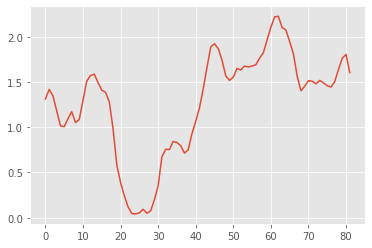

In [188]:
#plt.plot(realized_CPIC)
plt.plot(smm_ts_table.loc['SCE','AR','SE','FE',:].loc['Forecast','smm_ts'])

In [67]:
## data moments

smm_data_spf =  pd.DataFrame(data_moms_dct_SPF.values()).T
smm_data_spf.columns = data_moms_dct_SPF.keys()

smm_data_sce =  pd.DataFrame(data_moms_dct_SCE.values()).T
smm_data_sce.columns = data_moms_dct_SCE.keys()

In [68]:
mom_compare_spf = smm_data_spf.append(smm_model.loc['SPF'])
mom_compare_sce = smm_data_sce.append(smm_model.loc['SCE'])

mom_joint_compare_spf = smm_data_spf.append(smm_joint_model.loc['SPF','AR'])
mom_joint_compare_sce = smm_data_sce.append(smm_joint_model.loc['SCE','AR'])

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_15885/835143023.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mom_compare_spf = smm_data_spf.append(smm_model.loc['SPF'])
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_15885/835143023.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mom_compare_sce = smm_data_sce.append(smm_model.loc['SCE'])
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_15885/835143023.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  mom_joint_compare_spf = smm_data_spf.append(smm_joint_model.loc['SPF','AR'])
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_15885/835143023.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

In [69]:
## export 
mom_compare_spf.to_excel('./tables/spf_moments.xlsx')
mom_compare_sce.to_excel('./tables/sce_moments.xlsx')
mom_joint_compare_spf.to_excel('./tables/spf_joint_est_moments.xlsx')
mom_joint_compare_sce.to_excel('./tables/sce_joint_est_moments.xlsx')

In [70]:
mom_compare_spf

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV,Forecast
0,0.00,0.17,-0.04,0.12,0.14,-0.05,0.16,0.02,0.01,0.21,0.00,0.00,NaN
"(AR, SE, FE)",0.00,2.52,2.23,-0.06,0.18,NaN,0.02,0.00,NaN,0.61,0.00,NaN,1.79
"(AR, SE, FE+Disg)",0.00,2.52,2.23,-0.06,0.00,0.00,0.00,0.00,0.00,0.65,0.00,-0.00,0.36
"(AR, SE, FE+Disg+Var)",0.00,2.52,2.23,-0.01,0.01,0.00,0.01,0.00,0.00,0.62,0.00,-0.00,0.07
"(AR, NI, FE)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(AR, NI, FE+Disg)",0.00,2.52,2.23,-0.01,0.01,0.00,0.00,0.00,0.00,0.55,0.00,0.00,0.07
"(AR, NI, FE+Disg+Var)",0.00,2.52,2.23,0.00,0.00,0.00,0.00,0.00,0.00,0.55,0.00,0.00,-0.00
"(AR, DE, FE)",0.00,2.52,2.23,0.00,0.00,0.00,0.00,0.00,0.00,0.55,0.00,0.00,-0.01
"(AR, DE, FE+Disg)",0.00,2.52,2.23,-0.00,0.01,0.00,0.01,0.00,-0.00,0.55,0.00,0.00,0.03
"(AR, DE, FE+Disg+Var)",0.00,2.52,2.23,-0.00,0.01,0.00,0.01,0.00,-0.00,0.55,0.00,0.00,0.03


In [71]:
mom_joint_compare_spf

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV,Forecast
0,0.00,0.17,-0.04,0.12,0.14,-0.05,0.16,0.02,0.01,0.21,0.00,0.00,NaN
"(SE, FE)",0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.42
"(SE, FE+Disg)",0.00,0.25,0.20,-0.02,0.03,0.02,0.01,0.00,0.00,0.12,0.00,-0.00,0.06
"(SE, FE+Disg+Var)",0.00,0.25,0.20,-0.02,0.03,0.02,0.01,0.00,0.00,0.12,0.00,-0.00,0.06
"(NI, FE)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(NI, FE+Disg)",0.00,0.08,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,-0.01
"(NI, FE+Disg+Var)",0.00,0.13,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,-0.01
"(DE, FE)",0.00,0.06,0.05,-0.01,0.01,0.00,0.00,0.00,-0.00,0.02,0.00,0.00,0.03
"(DE, FE+Disg)",0.00,0.06,0.05,-0.01,0.01,0.00,0.01,0.00,-0.00,0.02,0.00,0.00,0.03
"(DE, FE+Disg+Var)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
mom_compare_sce

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV,Forecast
0,0.00,0.65,0.61,1.75,0.92,0.88,2.60,0.07,0.02,1.75,0.03,0.00,NaN
"(AR, SE, FE)",0.00,5.53,4.61,0.15,0.25,0.15,0.11,0.01,0.00,1.88,0.00,-0.00,-0.61
"(AR, SE, FE+Disg)",0.00,5.53,4.61,-0.09,0.34,0.18,0.16,0.01,0.00,1.96,0.00,-0.00,0.38
"(AR, SE, FE+Disg+Var)",0.00,5.53,4.61,-0.09,0.28,0.17,0.12,0.01,0.00,1.88,0.00,-0.00,0.39
"(AR, NI, FE)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(AR, NI, FE+Disg)",0.00,5.53,4.61,0.02,0.24,0.09,0.01,0.00,0.00,1.70,0.00,0.00,-0.10
"(AR, NI, FE+Disg+Var)",0.00,5.53,4.61,0.11,0.38,0.06,0.03,0.00,-0.00,1.98,0.00,0.00,0.02
"(AR, DE, FE)",0.00,5.53,4.61,0.01,0.28,0.06,0.04,0.00,0.00,1.69,0.00,0.00,-0.07
"(AR, DE, FE+Disg)",0.00,5.53,4.61,-0.06,0.07,0.03,0.40,0.28,-0.01,1.69,0.00,0.00,0.28
"(AR, DE, FE+Disg+Var)",0.00,5.53,4.61,-0.05,0.33,0.02,0.59,0.62,-0.03,1.69,0.00,0.00,0.29


In [52]:
mom_joint_compare_sce

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV,Forecast
0,0.00,0.65,0.61,1.75,0.92,0.88,2.60,0.07,0.02,1.75,0.03,0.00,NaN
"(SE, FE)",0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.51
"(SE, FE+Disg)",0.00,0.25,0.20,-0.02,0.03,0.02,0.01,0.00,0.00,0.12,0.00,-0.00,0.06
"(SE, FE+Disg+Var)",0.00,0.25,0.20,-0.02,0.03,0.02,0.01,0.00,0.00,0.12,0.00,-0.00,0.06
"(NI, FE)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(NI, FE+Disg)",0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.12
"(NI, FE+Disg+Var)",0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.12
"(DE, FE)",0.00,0.41,0.36,-0.01,0.00,0.00,0.00,0.00,-0.00,0.09,0.00,0.00,0.09
"(DE, FE+Disg)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(DE, FE+Disg+Var)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
